# Riesz Representation of sensors

In [1]:
from dolfinx.mesh import create_interval
from dolfinx.fem import FunctionSpace, Function
from mpi4py import MPI
from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.backends import norms
import numpy as np

import matplotlib.pyplot as plt

## 1D

In [3]:
domain = create_interval(MPI.COMM_WORLD, 1000, [0, 10])
V = FunctionSpace(domain, ("CG", 1))
norm = norms(V, is_H1=True)

x = domain.geometry.x[:,0]

xm = 3
points_spread = [0.1, 0.2, 1]
kernel = FunctionsList(V)
tmp = Function(V)

for s in points_spread:
    tmp.interpolate(lambda x: np.exp(- ((x[0] - xm)**2) / (2 * s**2)))
    integral = norm.integral(tmp)
    kernel.append(tmp.x.array[:] / integral)

    print(f"Integral of kernel with spread {s}: {norm.integral(kernel(-1))}")

Integral of kernel with spread 0.1: 1.0
Integral of kernel with spread 0.2: 1.0
Integral of kernel with spread 1: 0.9999999999999967


The kernel is the representation of the sensor in $L^2$.
We need to solve the weak problem for the representation of the kernel in $H^1$.

In [5]:
import ufl
from dolfinx.fem.petsc import LinearProblem

def H1representation(kernel_fun):
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + u * v * ufl.dx
    L = kernel_fun * v * ufl.dx

    problem = LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem.solve()

h1_repre = FunctionsList(V)
for ii in range(len(kernel)):
    h1_repre.append(H1representation(kernel.map(ii)))

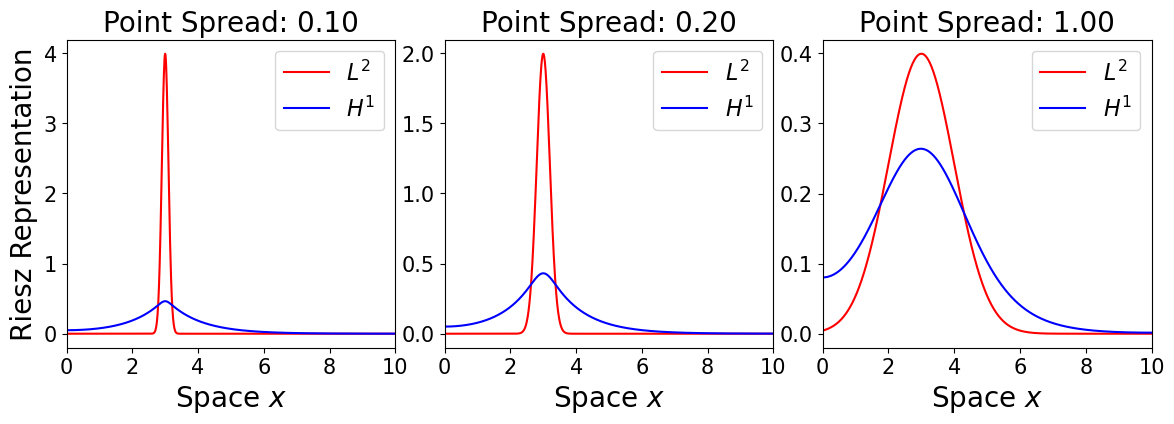

In [6]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(14, 4))

for ii, s in enumerate(points_spread):
    axs[ii].plot(x, kernel(ii), 'r', label=r"$L^2$")
    axs[ii].plot(x, h1_repre(ii), 'b', label=r"$H^1$")

    axs[ii].set_xlabel(r"Space $x$", fontsize=20)
    axs[ii].legend(fontsize=16)
    axs[ii].set_title(f"Point Spread: {s:.2f}", fontsize=20)
    axs[ii].set_xlim(min(x), max(x))
    axs[ii].tick_params(labelsize=15)

axs[0].set_ylabel("Riesz Representation", fontsize=20)

fig.subplots_adjust(wspace=0.15)
# fig.savefig("1D_riesz_comparison.pdf",format='pdf', dpi=200, bbox_inches="tight")

## 2D

In [8]:
from dolfinx.mesh import create_rectangle, CellType

domain = create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([10, 10])],
                               [200, 200], CellType.triangle)

V = FunctionSpace(domain, ("CG", 1))
norm = norms(V, is_H1=True)

x = domain.geometry.x[:,0]

xm = [2, 10, 0]
points_spread = [0.1, 0.25, 0.5]
kernel = FunctionsList(V)
tmp = Function(V)

for s in points_spread:
    tmp.interpolate(lambda x: np.exp(- ((x[0]-xm[0])**2 + (x[1]-xm[1])**2) / (2 * s**2)))
    integral = norm.integral(tmp)
    kernel.append(tmp.x.array[:] / integral)

    print(f"Integral of kernel with spread {s}: {norm.integral(kernel(-1))}")

Integral of kernel with spread 0.1: 1.0000000000000013
Integral of kernel with spread 0.25: 0.9999999999999967
Integral of kernel with spread 0.5: 1.0000000000000004


The kernel is the representation of the sensor in $L^2$.
We need to solve the weak problem for the representation of the kernel in $H^1$.

In [10]:
import ufl
from dolfinx.fem.petsc import LinearProblem

def H1representation(kernel_fun):
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + u * v * ufl.dx
    L = kernel_fun * v * ufl.dx

    problem = LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem.solve()

h1_repre = FunctionsList(V)
for ii in range(len(kernel)):
    h1_repre.append(H1representation(kernel.map(ii)))

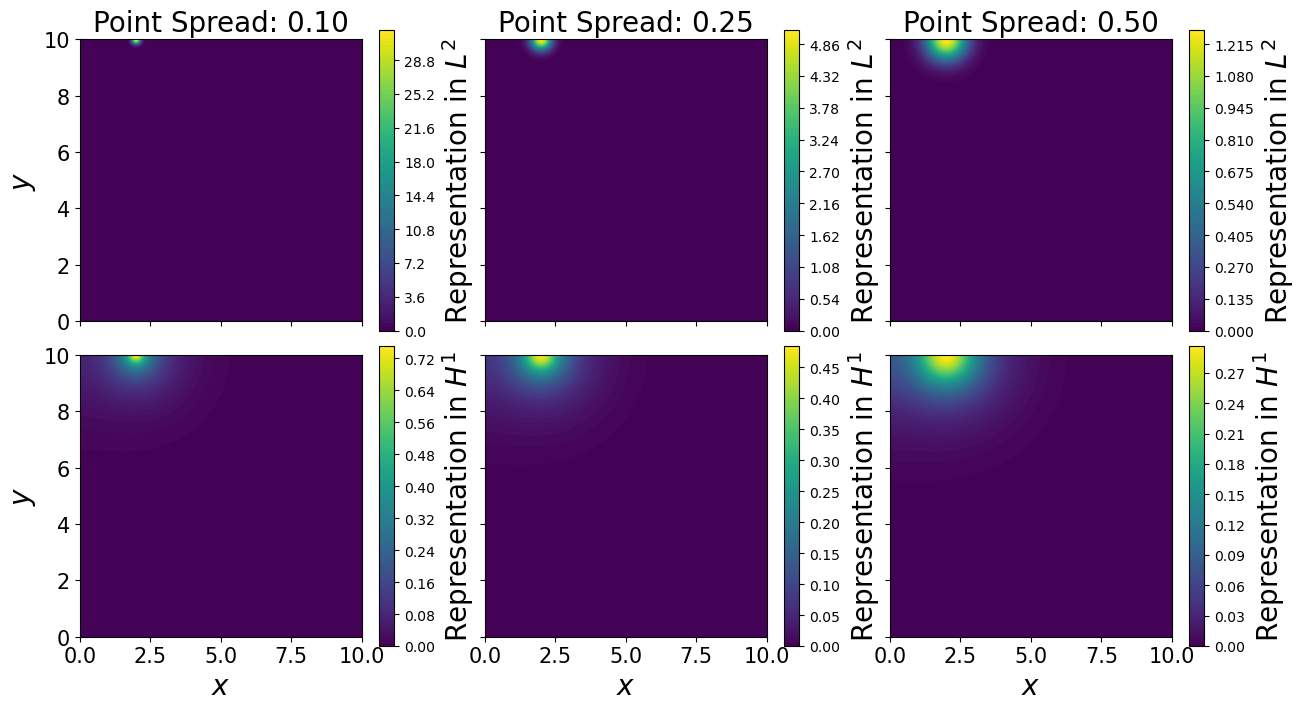

In [12]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 8))

cmaps = [
    'viridis',
    'viridis',
    'viridis',
]
for ii, s in enumerate(points_spread):
    l2_cont = axs[0, ii].tricontourf(*domain.geometry.x.T[:2], kernel(ii), cmap=cmaps[ii], levels=100)
    h1_cont = axs[1, ii].tricontourf(*domain.geometry.x.T[:2], h1_repre(ii), cmap=cmaps[ii], levels=100)

    fig.colorbar(l2_cont, ax=axs[0, ii]).set_label('Representation in $L^2$', fontsize=20)
    fig.colorbar(h1_cont, ax=axs[1, ii]).set_label('Representation in $H^1$', fontsize=20)

    axs[0, ii].set_title(f"Point Spread: {s:.2f}", fontsize=20)

for ax in axs.flatten():
    ax.set_aspect("equal")
    ax.tick_params(labelsize=15)

[axs[1, ii].set_xlabel("$x$", fontsize=20) for ii in range(len(points_spread))]
[axs[ii, 0].set_ylabel("$y$", fontsize=20) for ii in range(2)]

fig.subplots_adjust(wspace=0.15, hspace=0.05)
# fig.savefig("2D_riesz_comparison.png",format='png', dpi=300, bbox_inches="tight")